Classification of Iris Using MLP

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:

df = pd.read_csv('iris.csv')

In [ ]:
import torch
from torch.utils.data import (
    DataLoader,
    TensorDataset,
    Dataset
)

In [ ]:

def make_dataset(df: pd.DataFrame) -> Dataset:
    
    features = torch.tensor(df[df.columns[:-1]].values, dtype=torch.float32)
    targets = torch.tensor(df[df.columns[-1]].values, dtype=torch.int64)
    
    return TensorDataset(features, targets)
    
    

In [ ]:

train_dataset = make_dataset(df)
(x, y) = train_dataset[0]
print(f"First input {x}.  Its dtype must be {x.dtype}.")
print(f"First output {y}.  Its dtype must be {y.dtype}.")

First input tensor([6.1000, 2.8000, 4.7000, 1.2000]).  Its dtype must be torch.float32.
First output 1.  Its dtype must be torch.int64.


implement `make_dataloader` which converts
`Dataset` to `DataLoader` with specified `batch_size` and `shuffle` flag.

Refer to https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

In [ ]:

def make_dataloader(dataset: Dataset, batch_size:int, shuffle:bool) -> DataLoader:
    return DataLoader(dataset, batch_size, shuffle=shuffle)

In [ ]:

train_dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=5)
first_batch = next(iter(train_dataloader))
first_batch

[tensor([[6.1000, 2.8000, 4.7000, 1.2000],
         [5.4000, 3.9000, 1.3000, 0.4000],
         [6.5000, 3.0000, 5.8000, 2.2000],
         [5.1000, 3.5000, 1.4000, 0.3000],
         [5.9000, 3.0000, 4.2000, 1.5000]]),
 tensor([1, 0, 2, 0, 1])]

implement a neural network module that performs
simple linear classification.

$$ y_\mathrm{pred} = xW + b $$

`nn.Linear(...)` as a layer,
name the attribute in the `LinearClassifier` as `linear`

In [ ]:
from torch import nn
from torchinfo import summary

In [ ]:

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,3)
        
    def forward(self, x):
        return self.linear(x)

In [ ]:

m = LinearClassifier()
summary(m, input_size=(32,4))

Layer (type:depth-idx)                   Output Shape              Param #
LinearClassifier                         [32, 3]                   --
├─Linear: 1-1                            [32, 3]                   15
Total params: 15
Trainable params: 15
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

training loop to train the linear classifier and inspect the accuracy.

In [ ]:
from torch.optim import (Optimizer, Adam)
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy

In [ ]:
def train(model: nn.Module, optimizer: Optimizer, dataloader: DataLoader, epochs: int):
    history = []
    accuracy = Accuracy(task='multiclass', num_classes=3)
    for epoch in range(epochs):
        for (x, target) in dataloader:
            pred = model(x)
            loss = cross_entropy(pred, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        metrics = {
            'epoch': epoch,
            'loss': loss.item(),
            'acc': accuracy(pred, target).item()
        }
        if epoch % (epochs // 10) == 0:
            print("{epoch}: loss={loss:.4f}, acc={acc:.2f}".format(**metrics))
        history.append(metrics)
    return pd.DataFrame(history)

In [ ]:

dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=32)
linearclassifier = LinearClassifier()
optimizer = Adam(linearclassifier.parameters(), lr=0.001)

history_linear = train(linearclassifier, optimizer, dataloader, 100)

0: loss=1.8345, acc=0.41
10: loss=1.3996, acc=0.41
20: loss=1.1631, acc=0.59
30: loss=1.0336, acc=0.77
40: loss=0.9858, acc=0.77
50: loss=0.9510, acc=0.73
60: loss=0.9100, acc=0.77
70: loss=0.8680, acc=0.77
80: loss=0.8281, acc=0.77
90: loss=0.7911, acc=0.77


In [ ]:

print("linear classifier acc > 50%?", history_linear.acc.iloc[-1] > 0.5)
print("linear classifier acc < 90%?", history_linear.acc.iloc[-1] < 0.9)

linear classifier acc > 50%? True
linear classifier acc < 90%? True


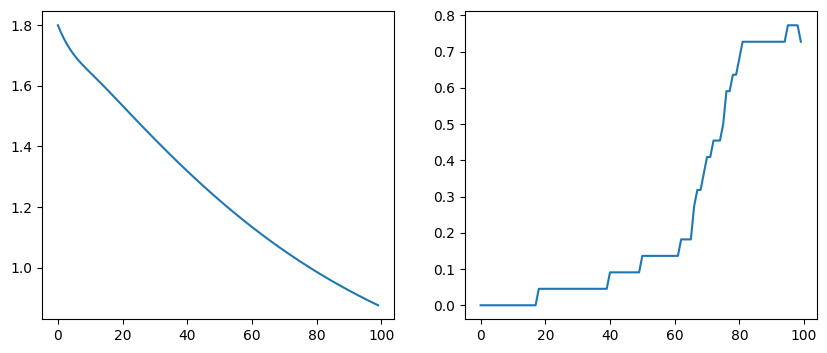

In [ ]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
history_linear.loss.plot.line(ax=axes[0])
history_linear.acc.plot.line(ax=axes[1]);



 a multi-layer perceptron (MLP)
with a single hidden layer of 100 neurons.

- `linear1`: the hidden layer with 100 neurons.
- `act1`: the ReLU activation function.
- `output`: the output layer that outputs the logits over the 3 categories.

Refer to: http://db.science.uoit.ca/csci4050u/2_fitting_2d/03_mlp.html

In [ ]:

class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(4, 100)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(100, 3)
        

    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.output(x)
        return x


In [ ]:

m = MLPClassifier()
summary(m, input_size=(32,4))

Layer (type:depth-idx)                   Output Shape              Param #
MLPClassifier                            [32, 3]                   --
├─Linear: 1-1                            [32, 100]                 500
├─ReLU: 1-2                              [32, 100]                 --
├─Linear: 1-3                            [32, 3]                   303
Total params: 803
Trainable params: 803
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [ ]:

# training the MLP model

mlp = MLPClassifier()
optimizer = Adam(mlp.parameters())
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=32)

history_mlp = train(mlp, optimizer, dataloader, 100)

0: loss=1.1802, acc=0.23
10: loss=0.5976, acc=0.82
20: loss=0.4076, acc=0.91
30: loss=0.3173, acc=0.95
40: loss=0.2554, acc=0.95
50: loss=0.2079, acc=0.95
60: loss=0.1719, acc=0.95
70: loss=0.1450, acc=0.95
80: loss=0.1247, acc=0.95
90: loss=0.1094, acc=0.95


In [ ]:

history_mlp.acc.iloc[-1] > 0.9

True

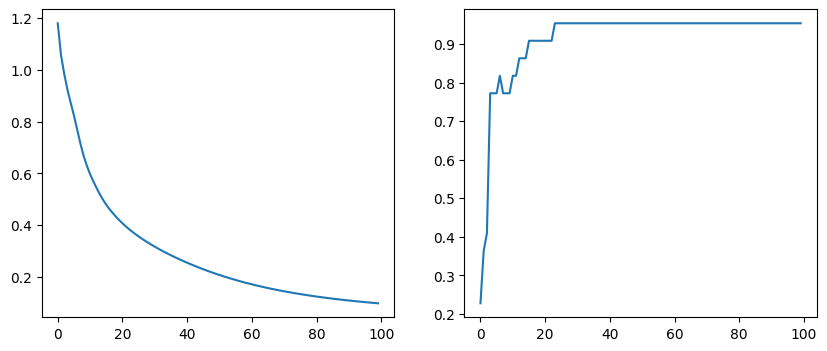

In [ ]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
history_mlp.loss.plot.line(ax=axes[0])
history_mlp.acc.plot.line(ax=axes[1]);


generating 2D hidden features and visualize the generated features as a scatter plot.

- `MLP2DClassifier` neural network consisting of the following layers:

- `linear1` is a linear layer with 100 neurons.
- `act1` is the ReLU activation function for the `linear1` layer.
- `linear2` is a linear layer that maps the 100 dimensional hidden feature to 2 dimensional feature.
- `output` is a linear layer that maps the 2D feature to 3D logits.

It is the output of `linear2` layer provides insight into how `x2 = act1(linear1(x))` works.

- MLP2DClassifier` will have an additional method
`hiddenFeature(x)` that will return the output of `linear2`.

In [ ]:

class MLP2DClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,100)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 2)
        self.output = nn.Linear(2,3)
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.output(x)
        
        return x
    
    def hiddenFeature(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        
        return x

In [ ]:

m = MLP2DClassifier()
summary(m, input_size=(32, 4))

Layer (type:depth-idx)                   Output Shape              Param #
MLP2DClassifier                          [32, 3]                   --
├─Linear: 1-1                            [32, 100]                 500
├─ReLU: 1-2                              [32, 100]                 --
├─Linear: 1-3                            [32, 2]                   202
├─Linear: 1-4                            [32, 3]                   9
Total params: 711
Trainable params: 711
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [ ]:
mlp2 = MLP2DClassifier()
optimizer = Adam(mlp2.parameters())
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=32)

history_mlp2 = train(mlp2, optimizer, dataloader, 100)

0: loss=1.3717, acc=0.23
10: loss=0.5941, acc=0.86
20: loss=0.3666, acc=0.95
30: loss=0.2684, acc=0.95
40: loss=0.2004, acc=0.95
50: loss=0.1522, acc=0.95
60: loss=0.1195, acc=0.95
70: loss=0.0978, acc=0.95
80: loss=0.0833, acc=0.95
90: loss=0.0733, acc=0.95


In [ ]:

history_mlp2.acc.iloc[-1] > 0.9

True

In [ ]:


(x, target) = train_dataset[0:100]
with torch.no_grad():
    x2 = mlp2.hiddenFeature(x)

In [ ]:

x2.shape

torch.Size([100, 2])

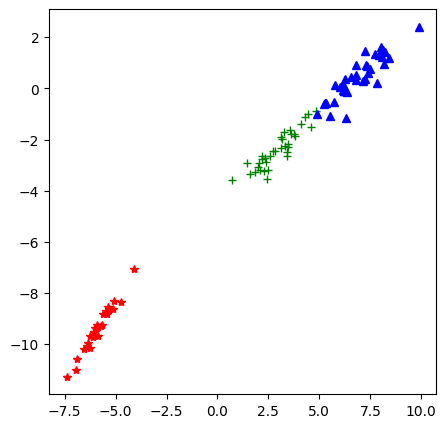

In [ ]:


I0 = target == 0
I1 = target == 1
I2 = target == 2

plt.figure(figsize=(5,5))
plt.plot(x2[I0, 0], x2[I0, 1], '*', color='red');
plt.plot(x2[I1, 0], x2[I1, 1], '+', color='green');
plt.plot(x2[I2, 0], x2[I2, 1], '^', color='blue');